In [2]:
import os
import numpy as np
import pandas as pd
import torch
import os
import json
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm
import glob
import pickle
import glob
import os.path as osp
DATA_DIR = '/mnt/chicm/data/open-images/relation'
DETECT_DATA_DIR = '/mnt/chicm/data/open-images/detect'
IMG_DIR = '/mnt/chicm/data/open-images/train/imgs'
TEST_IMG_DIR = '/mnt/chicm/data/open-images/test'

In [3]:
img_files = glob.glob(IMG_DIR + '/**/*.jpg')
fullpath_dict = {}
for fn in img_files:
    fullpath_dict[osp.basename(fn).split('.')[0]] = fn

In [4]:
fullpath_dict['780d8a470d144fa0']

'/mnt/chicm/data/open-images/train/imgs/train_7/780d8a470d144fa0.jpg'

In [5]:
!ls $DATA_DIR

challenge-2019-attributes-description.csv
challenge-2019-classes-vrd.csv
challenge-2019-relationships-description.csv
challenge-2019-relationship-triplets.csv
challenge-2019-train-vrd-bbox.csv
challenge-2019-train-vrd.csv
challenge-2019-train-vrd-labels.csv
challenge-2019-validation-vrd-bbox.csv
challenge-2019-validation-vrd.csv
challenge-2019-validation-vrd-labels.csv
classes_is_42.csv
negative_tuples.csv
top_classes.csv
VRD_sample_submission.csv


In [6]:
df_classes = pd.read_csv(osp.join(DATA_DIR, 'challenge-2019-classes-vrd.csv'), names=['classes', 'desc'])
#df_classes.head()
def get_class_name(label):
    return df_classes.loc[df_classes.classes==label].desc.values[0]

In [7]:
df_box = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-train-vrd-bbox.csv'))
                     #dtype={'XMin':str, 'XMax':str, 'YMin': str, 'YMax': str})
df_box.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax,IsGroupOf
0,780d8a470d144fa0,/m/04yx4,0.000000,0.527143,0.029979,0.997859,0
1,780d8a470d144fa0,/m/04yx4,0.291429,0.687143,0.128480,0.997859,0
2,780d8a470d144fa0,/m/04yx4,0.590000,0.965714,0.164882,0.997859,0
3,780db0a7d07a4a20,/m/026t6,0.000000,1.000000,0.345625,0.990000,-1
4,780db0a7d07a4a20,/m/026t6,0.271667,0.626667,0.803125,0.999375,0


In [8]:
df_box.shape

(3290070, 7)

In [9]:
df_vrd = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-train-vrd.csv'))
    #converters={
    #'XMin1':lambda x: '{:.6f}'.format(float(x)),
    #'XMax1':lambda x: '{:.6f}'.format(float(x)),
    #'YMin1':lambda x: '{:.6f}'.format(float(x)),
    #'YMax1':lambda x: '{:.6f}'.format(float(x))})
df_vrd.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
0,fe58ec1b06db2bb7,/m/04bcr3,/m/083vt,0.00500,0.033125,0.580000,0.627778,0.00500,0.033125,0.580000,0.627778,is
1,82d16a22f703df5c,/m/04dr76w,/m/02gy9n,0.61200,0.735000,0.418919,0.950450,0.61200,0.735000,0.418919,0.950450,is
2,b54d41beabcfd900,/m/01mzpv,/m/083vt,0.37250,0.399375,0.706413,0.778557,0.37250,0.399375,0.706413,0.778557,is
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.17125,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.85500,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at


In [10]:
df_vrd.shape

(374768, 12)

In [11]:
df_pos = df_vrd.loc[df_vrd.RelationshipLabel!='is'].copy()

In [12]:
df_pos.RelationshipLabel.value_counts()

at                111493
on                 31604
holds              20986
plays               8932
interacts_with      3756
inside_of           2392
wears                836
hits                 593
under                 34
Name: RelationshipLabel, dtype: int64

In [13]:
print(df_pos.shape, len(df_pos.ImageID.unique()), len(df_pos.LabelName1.unique()),\
      len(df_pos.LabelName2.unique()), len(df_pos.RelationshipLabel.unique()))

(180626, 12) 57187 17 53 9


In [14]:
classes_1 = df_pos.LabelName1.unique()
print(classes_1, len(classes_1))
print([get_class_name(x) for x in classes_1])

['/m/01mzpv' '/m/04yx4' '/m/03bt1vf' '/m/05r655' '/m/01bl7v' '/m/04dr76w'
 '/m/09tvcd' '/m/02p5f1q' '/m/02jvh9' '/m/0dt3t' '/m/0bt9lr' '/m/0cmx8'
 '/m/01599' '/m/04ctx' '/m/01yrx' '/m/01_5g' '/m/03qrc'] 17
['Chair', 'Man', 'Woman', 'Girl', 'Boy', 'Bottle', 'Wine glass', 'Coffee cup', 'Mug', 'Fork', 'Dog', 'Spoon', 'Beer', 'Knife', 'Cat', 'Chopsticks', 'Hamster']


In [15]:
classes_2 = df_pos.LabelName2.unique()
print(classes_2, len(classes_2))
print([get_class_name(x) for x in classes_2])


['/m/01y9k5' '/m/04bcr3' '/m/0199g' '/m/078n6m' '/m/05_5p_0' '/m/01mzpv'
 '/m/0hg7b' '/m/0k4j' '/m/0dv5r' '/m/0dv9c' '/m/0342h' '/m/09tvcd'
 '/m/01226z' '/m/050k8' '/m/0cvnqh' '/m/0bt9lr' '/m/04_sv' '/m/01599'
 '/m/04dr76w' '/m/07y_7' '/m/03ssj5' '/m/080hkjn' '/m/026t6' '/m/02p5f1q'
 '/m/03m3pdh' '/m/03k3r' '/m/0h8my_4' '/m/0wdt60w' '/m/071p9' '/m/0pg52'
 '/m/01940j' '/m/06__v' '/m/05r5c' '/m/0cmx8' '/m/0l14j_' '/m/04ctx'
 '/m/019w40' '/m/01yrx' '/m/0bwd_0j' '/m/01_5g' '/m/0h2r6' '/m/08pbxl'
 '/m/01s55n' '/m/01f91_' '/m/02jvh9' '/m/0584n8' '/m/078jl' '/m/02hj4'
 '/m/05ctyq' '/m/03qrc' '/m/0dt3t' '/m/029bxz' '/m/0fx9l'] 53
['Desk', 'Table', 'Bicycle', 'Coffee table', 'Table tennis racket', 'Chair', 'Microphone', 'Car', 'Camera', 'Racket', 'Guitar', 'Wine glass', 'Football', 'Mobile phone', 'Bench', 'Dog', 'Motorcycle', 'Beer', 'Bottle', 'Violin', 'Bed', 'Handbag', 'Drum', 'Coffee cup', 'Sofa bed', 'Horse', 'Tennis racket', 'Rugby ball', 'Ski', 'Taxi', 'Backpack', 'Snowboard', 'Piano', '

In [16]:
print(set(classes_1) - set(classes_2))

{'/m/03bt1vf', '/m/01bl7v', '/m/05r655', '/m/04yx4'}


In [17]:
df_trip = pd.read_csv(osp.join(DATA_DIR, 'challenge-2019-relationship-triplets.csv'))
df_trip_tuple = df_trip.loc[df_trip.RelationshipLabel!='is']
df_trip_tuple.shape

(287, 3)

In [18]:
pos_img_ids = set(df_pos.ImageID.values)
#len(pos_img_ids)
list(pos_img_ids)[:2]

['f110c723f32fde59', 'aebf8505fe5f44e2']

In [19]:
tuple_classes = set(classes_1) | set(classes_2)
print(len(tuple_classes), list(tuple_classes)[:2])

57 ['/m/078n6m', '/m/03bt1vf']


In [20]:
len(df_box.ImageID.unique())

790478

In [138]:
df_box_neg = df_box.loc[~df_box.ImageID.isin(pos_img_ids)]
len(df_box_neg.ImageID.unique())

733291

In [139]:
groups = list(df_box_neg.groupby('ImageID'))

In [140]:
groups[0]

('000002b66c9c498e',
                  ImageID  LabelName      XMin      XMax      YMin      YMax  \
 909088  000002b66c9c498e  /m/04bcr3  0.064062  0.492188  0.889063  0.993750   
 909089  000002b66c9c498e  /m/04bcr3  0.301562  0.990625  0.462500  0.595312   
 909090  000002b66c9c498e  /m/04bcr3  0.312500  0.578125  0.351562  0.464063   
 
         IsGroupOf  
 909088          0  
 909089          0  
 909090          0  )

In [141]:
type(groups[0][1].iloc[0].LabelName)

str

In [142]:
groups[0][1]

,ImageID,LabelName,XMin,XMax,YMin,YMax,IsGroupOf
909088,000002b66c9c498e,/m/04bcr3,0.064062,0.492188,0.889063,0.993750,0
909089,000002b66c9c498e,/m/04bcr3,0.301562,0.990625,0.462500,0.595312,0
909090,000002b66c9c498e,/m/04bcr3,0.312500,0.578125,0.351562,0.464063,0


In [143]:
len(groups)

733291

In [144]:
df_pos.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.171250,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.855000,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at
5,03b5764a5c600aa4,/m/04yx4,/m/0199g,0.114068,0.205323,0.334375,0.453750,0.13308,0.200570,0.383750,0.465625,on
6,d18adac47a838d35,/m/03bt1vf,/m/04bcr3,0.531875,0.597500,0.054409,0.196060,0.00000,0.999375,0.147280,0.447467,at
7,487e3f4413229d30,/m/04yx4,/m/04bcr3,0.281250,0.706875,0.103578,0.780603,0.00000,0.999375,0.731638,0.999058,at


In [145]:
import random
def get_neg_sample(group):
    img_id, group = group
    n = len(group.LabelName.values)
    if n < 2:
        return []
    used = set()
    result = []
    for _ in range(20):
        idx1 = random.choice(list(range(n)))
        idx2 = random.choice(list(range(n)))
        if (idx1 != idx2) and ((idx1, idx2) not in used):
            row1 = group.iloc[idx1]
            row2 = group.iloc[idx2]
            label_name1 = row1.LabelName
            label_name2 = row2.LabelName
            if label_name1 in set(classes_1) and label_name2 in set(classes_2):
                result.append({
                    'ImageID': img_id,
                    'LabelName1': label_name1,
                    'LabelName2': label_name2,
                    'XMin1': row1.XMin,
                    'XMax1': row1.XMax,
                    'YMin1': row1.YMin,
                    'YMax1': row1.YMax,
                    'XMin2': row2.XMin,
                    'XMax2': row2.XMax,
                    'YMin2': row2.YMin,
                    'YMax2': row2.YMax,
                    'RelationshipLabel': 'none'
                })
                #result.append((group.iloc[idx1], group.iloc[idx2]))
                used.add((idx1, idx2))
        if len(used) >= 10:
            break
    #print(len(result))
    return result

In [146]:
from multiprocessing import Pool
with Pool(50) as p:
    samples = list(tqdm(iterable=p.imap_unordered(get_neg_sample, groups), total=len(groups)))




  0%|          | 0/733291 [00:00<?, ?it/s]


  0%|          | 279/733291 [00:00<04:22, 2788.16it/s]


  0%|          | 574/733291 [00:00<04:18, 2834.80it/s]


  0%|          | 981/733291 [00:00<03:55, 3112.14it/s]


  0%|          | 1273/733291 [00:00<04:09, 2939.66it/s]


  0%|          | 1669/733291 [00:00<03:49, 3184.01it/s]


  0%|          | 2146/733291 [00:00<03:27, 3530.95it/s]


  0%|          | 2487/733291 [00:00<03:31, 3448.97it/s]


  0%|          | 2834/733291 [00:00<03:31, 3448.77it/s]


  0%|          | 3173/733291 [00:00<03:32, 3428.68it/s]


  0%|          | 3552/733291 [00:01<03:26, 3529.16it/s]


  1%|          | 3928/733291 [00:01<03:22, 3593.42it/s]


  1%|          | 4326/733291 [00:01<03:18, 3666.83it/s]


  1%|          | 4728/733291 [00:01<03:15, 3733.41it/s]


  1%|          | 5130/733291 [00:01<03:13, 3757.47it/s]


  1%|          | 5506/733291 [00:01<03:17, 3688.76it/s]


  1%|          | 5927/733291 [00:01<03:10, 3825.60it/s]


  1%|          | 6319/73329

 13%|█▎        | 97384/733291 [00:26<02:55, 3628.07it/s]


 13%|█▎        | 97820/733291 [00:26<02:49, 3752.52it/s]


 13%|█▎        | 98237/733291 [00:26<02:44, 3862.49it/s]


 13%|█▎        | 98629/733291 [00:26<03:06, 3399.25it/s]


 13%|█▎        | 98983/733291 [00:26<03:08, 3369.25it/s]


 14%|█▎        | 99374/733291 [00:26<03:14, 3252.03it/s]


 14%|█▎        | 99808/733291 [00:27<03:00, 3505.97it/s]


 14%|█▎        | 100170/733291 [00:27<03:01, 3493.61it/s]


 14%|█▎        | 100528/733291 [00:27<03:01, 3490.98it/s]


 14%|█▍        | 100965/733291 [00:27<02:51, 3680.60it/s]


 14%|█▍        | 101405/733291 [00:27<02:43, 3868.30it/s]


 14%|█▍        | 101838/733291 [00:27<02:38, 3978.19it/s]


 14%|█▍        | 102242/733291 [00:27<02:40, 3934.74it/s]


 14%|█▍        | 102671/733291 [00:27<02:36, 4034.38it/s]


 14%|█▍        | 103079/733291 [00:27<02:36, 4039.35it/s]


 14%|█▍        | 103504/733291 [00:27<02:34, 4064.18it/s]


 14%|█▍        | 103913/733291 [00:28<02:50, 36

 27%|██▋       | 195251/733291 [00:52<02:10, 4116.33it/s]


 27%|██▋       | 195682/733291 [00:52<02:20, 3836.48it/s]


 27%|██▋       | 196083/733291 [00:52<02:26, 3674.83it/s]


 27%|██▋       | 196464/733291 [00:52<02:33, 3486.94it/s]


 27%|██▋       | 196856/733291 [00:52<02:29, 3578.16it/s]


 27%|██▋       | 197262/733291 [00:52<02:24, 3701.89it/s]


 27%|██▋       | 197820/733291 [00:53<02:10, 4110.39it/s]


 27%|██▋       | 198251/733291 [00:53<02:14, 3976.55it/s]


 27%|██▋       | 198663/733291 [00:53<02:15, 3954.78it/s]


 27%|██▋       | 199069/733291 [00:53<02:14, 3966.03it/s]


 27%|██▋       | 199489/733291 [00:53<02:12, 4023.60it/s]


 27%|██▋       | 199897/733291 [00:53<02:30, 3548.08it/s]


 27%|██▋       | 200266/733291 [00:53<02:33, 3462.37it/s]


 27%|██▋       | 200640/733291 [00:53<02:33, 3464.10it/s]


 27%|██▋       | 200997/733291 [00:53<02:32, 3493.51it/s]


 27%|██▋       | 201377/733291 [00:54<02:30, 3543.88it/s]


 28%|██▊       | 201883/733291 [00:54<02

 40%|████      | 294605/733291 [01:17<01:57, 3744.30it/s]


 40%|████      | 294989/733291 [01:17<01:58, 3686.27it/s]


 40%|████      | 295462/733291 [01:18<01:51, 3941.45it/s]


 40%|████      | 295872/733291 [01:18<01:49, 3984.99it/s]


 40%|████      | 296288/733291 [01:18<01:48, 4035.69it/s]


 40%|████      | 296697/733291 [01:18<01:53, 3861.47it/s]


 41%|████      | 297143/733291 [01:18<01:48, 4019.79it/s]


 41%|████      | 297551/733291 [01:18<02:03, 3526.27it/s]


 41%|████      | 298115/733291 [01:18<01:49, 3972.89it/s]


 41%|████      | 298660/733291 [01:18<01:40, 4312.18it/s]


 41%|████      | 299120/733291 [01:18<01:42, 4227.71it/s]


 41%|████      | 299564/733291 [01:19<01:44, 4167.20it/s]


 41%|████      | 299996/733291 [01:19<01:54, 3796.12it/s]


 41%|████      | 300518/733291 [01:19<01:45, 4120.38it/s]


 41%|████      | 300950/733291 [01:19<01:43, 4178.25it/s]


 41%|████      | 301382/733291 [01:19<01:50, 3915.94it/s]


 41%|████      | 301787/733291 [01:19<01

 55%|█████▍    | 400273/733291 [01:43<01:22, 4043.11it/s]


 55%|█████▍    | 400687/733291 [01:44<01:22, 4051.53it/s]


 55%|█████▍    | 401136/733291 [01:44<01:19, 4165.69it/s]


 55%|█████▍    | 401558/733291 [01:44<01:21, 4053.16it/s]


 55%|█████▍    | 402000/733291 [01:44<01:19, 4154.55it/s]


 55%|█████▍    | 402420/733291 [01:44<01:27, 3765.77it/s]


 55%|█████▍    | 402813/733291 [01:44<01:27, 3758.72it/s]


 55%|█████▌    | 403322/733291 [01:44<01:21, 4073.58it/s]


 55%|█████▌    | 403784/733291 [01:44<01:18, 4222.30it/s]


 55%|█████▌    | 404217/733291 [01:44<01:27, 3772.05it/s]


 55%|█████▌    | 404814/733291 [01:45<01:17, 4216.93it/s]


 55%|█████▌    | 405264/733291 [01:45<01:19, 4115.61it/s]


 55%|█████▌    | 405696/733291 [01:45<01:20, 4058.59it/s]


 55%|█████▌    | 406117/733291 [01:45<01:19, 4099.30it/s]


 55%|█████▌    | 406538/733291 [01:45<01:22, 3954.59it/s]


 56%|█████▌    | 406986/733291 [01:45<01:20, 4071.46it/s]


 56%|█████▌    | 407400/733291 [01:45<01

 69%|██████▊   | 503742/733291 [02:09<00:58, 3908.11it/s]


 69%|██████▉   | 504142/733291 [02:09<00:59, 3860.14it/s]


 69%|██████▉   | 504545/733291 [02:09<00:58, 3899.89it/s]


 69%|██████▉   | 504947/733291 [02:09<00:58, 3925.82it/s]


 69%|██████▉   | 505343/733291 [02:10<00:59, 3862.83it/s]


 69%|██████▉   | 505746/733291 [02:10<00:58, 3910.72it/s]


 69%|██████▉   | 506139/733291 [02:10<00:58, 3859.74it/s]


 69%|██████▉   | 506580/733291 [02:10<00:56, 4009.47it/s]


 69%|██████▉   | 506997/733291 [02:10<00:56, 3997.37it/s]


 69%|██████▉   | 507409/733291 [02:10<00:56, 4019.72it/s]


 69%|██████▉   | 507813/733291 [02:10<00:56, 3992.23it/s]


 69%|██████▉   | 508214/733291 [02:10<00:56, 3970.16it/s]


 69%|██████▉   | 508649/733291 [02:10<00:55, 4075.91it/s]


 69%|██████▉   | 509104/733291 [02:10<00:53, 4191.69it/s]


 69%|██████▉   | 509525/733291 [02:11<00:54, 4136.98it/s]


 70%|██████▉   | 509941/733291 [02:11<00:54, 4106.56it/s]


 70%|██████▉   | 510353/733291 [02:11<00

 83%|████████▎ | 610848/733291 [02:35<00:30, 4024.49it/s]


 83%|████████▎ | 611389/733291 [02:35<00:28, 4341.72it/s]


 83%|████████▎ | 611845/733291 [02:35<00:30, 4019.49it/s]


 84%|████████▎ | 612334/733291 [02:36<00:28, 4179.36it/s]


 84%|████████▎ | 612784/733291 [02:36<00:28, 4270.47it/s]


 84%|████████▎ | 613223/733291 [02:36<00:29, 4125.73it/s]


 84%|████████▎ | 613645/733291 [02:36<00:29, 4098.52it/s]


 84%|████████▎ | 614062/733291 [02:36<00:31, 3824.57it/s]


 84%|████████▍ | 614752/733291 [02:36<00:26, 4414.69it/s]


 84%|████████▍ | 615303/733291 [02:36<00:25, 4691.73it/s]


 84%|████████▍ | 615805/733291 [02:36<00:26, 4418.31it/s]


 84%|████████▍ | 616273/733291 [02:36<00:28, 4118.68it/s]


 84%|████████▍ | 616707/733291 [02:37<00:30, 3865.01it/s]


 84%|████████▍ | 617113/733291 [02:37<00:30, 3786.75it/s]


 84%|████████▍ | 617506/733291 [02:37<00:31, 3687.74it/s]


 84%|████████▍ | 617918/733291 [02:37<00:30, 3807.53it/s]


 84%|████████▍ | 618307/733291 [02:37<00

 98%|█████████▊| 719264/733291 [03:01<00:03, 4401.64it/s]


 98%|█████████▊| 719722/733291 [03:01<00:03, 4366.52it/s]


 98%|█████████▊| 720171/733291 [03:01<00:03, 4073.20it/s]


 98%|█████████▊| 720591/733291 [03:02<00:03, 4084.61it/s]


 98%|█████████▊| 721102/733291 [03:02<00:02, 4344.83it/s]


 98%|█████████▊| 721578/733291 [03:02<00:02, 4459.05it/s]


 98%|█████████▊| 722033/733291 [03:02<00:02, 4449.29it/s]


 99%|█████████▊| 722484/733291 [03:02<00:02, 4402.79it/s]


 99%|█████████▊| 722929/733291 [03:02<00:02, 4275.56it/s]


 99%|█████████▊| 723364/733291 [03:02<00:02, 4294.74it/s]


 99%|█████████▊| 723797/733291 [03:02<00:02, 4186.16it/s]


 99%|█████████▉| 724219/733291 [03:02<00:02, 4163.58it/s]


 99%|█████████▉| 724638/733291 [03:03<00:02, 3956.96it/s]


 99%|█████████▉| 725097/733291 [03:03<00:01, 4125.10it/s]


 99%|█████████▉| 725517/733291 [03:03<00:01, 4136.08it/s]


 99%|█████████▉| 725934/733291 [03:03<00:01, 4074.55it/s]


 99%|█████████▉| 726344/733291 [03:03<00

In [147]:
neg_samples = []
for results in samples:
    for r in results:
        neg_samples.append(r)

In [148]:
len(neg_samples)

189357

In [149]:
df_neg = pd.DataFrame(neg_samples)
df_neg.head()

,ImageID,LabelName1,LabelName2,RelationshipLabel,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2
0,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.93750,0.33750,0.67750,0.07125,0.998288,0.991438,0.164384,0.148973
1,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.93750,0.63625,0.67750,0.36750,0.998288,0.988014,0.164384,0.155822
2,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.63625,0.93750,0.36750,0.67750,0.988014,0.998288,0.155822,0.164384
3,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.63625,0.33750,0.36750,0.07125,0.988014,0.991438,0.155822,0.148973
4,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.33750,0.93750,0.07125,0.67750,0.991438,0.998288,0.148973,0.164384


In [157]:
df_neg.to_csv(osp.join(DATA_DIR, 'negative_tuples.csv'), index=False)

In [21]:
df_neg = pd.read_csv(osp.join(DATA_DIR, 'negative_tuples.csv'))
df_neg.head()

,ImageID,LabelName1,LabelName2,RelationshipLabel,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2
0,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.93750,0.33750,0.67750,0.07125,0.998288,0.991438,0.164384,0.148973
1,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.93750,0.63625,0.67750,0.36750,0.998288,0.988014,0.164384,0.155822
2,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.63625,0.93750,0.36750,0.67750,0.988014,0.998288,0.155822,0.164384
3,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.63625,0.33750,0.36750,0.07125,0.988014,0.991438,0.155822,0.148973
4,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.33750,0.93750,0.07125,0.67750,0.991438,0.998288,0.148973,0.164384


In [23]:
def get_iou(row):
    #assert row['XMin1'] <= row['XMax1']
    #assert row['YMin1'] <= row['YMax1']
    #assert row['XMin2'] <= row['XMax2']
    #assert row['YMin2'] <= row['YMax2']

    # determine the coordinates of the intersection rectangle
    x_left = max(row['XMin1'], row['XMin2'])
    y_top = max(row['YMin1'], row['YMin2'])
    x_right = min(row['XMax1'], row['XMax2'])
    y_bottom = min(row['YMax1'], row['YMax2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (row['XMax1'] - row['XMin1']) * (row['YMax1'] - row['YMin1'])
    bb2_area = (row['XMax2'] - row['XMin2']) * (row['YMax2'] - row['YMin2'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [24]:
get_iou(df_neg.iloc[4])

0.0

##  Generate training data

In [25]:
df_train = pd.concat([df_pos, df_neg], axis=0, sort=False)
df_train.shape

(369983, 12)

In [26]:
df_train.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.171250,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.855000,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at
5,03b5764a5c600aa4,/m/04yx4,/m/0199g,0.114068,0.205323,0.334375,0.453750,0.13308,0.200570,0.383750,0.465625,on
6,d18adac47a838d35,/m/03bt1vf,/m/04bcr3,0.531875,0.597500,0.054409,0.196060,0.00000,0.999375,0.147280,0.447467,at
7,487e3f4413229d30,/m/04yx4,/m/04bcr3,0.281250,0.706875,0.103578,0.780603,0.00000,0.999375,0.731638,0.999058,at


In [27]:
from sklearn.utils import shuffle
df_train = shuffle(df_train)
df_train.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
38275,82edc98d65932c98,/m/01mzpv,/m/04bcr3,0.844000,0.918000,0.596386,0.801205,0.346000,0.998000,0.590361,0.969880,at
78404,5e4f3703d0974896,/m/04yx4,/m/04bcr3,0.134766,0.184570,0.325217,0.739130,0.045898,0.470703,0.580870,0.876522,at
152179,c991d524e51cdaac,/m/01mzpv,/m/01mzpv,0.733125,0.785000,0.458333,0.606667,0.630000,0.758750,0.485833,0.806667,none
338132,e40274822215c7f5,/m/04yx4,/m/04bcr3,0.358125,0.430000,0.482075,0.619811,0.000000,0.999375,0.625472,0.833962,at
30440,eae30bd7355f20c5,/m/03bt1vf,/m/0h8my_4,0.121951,0.899312,0.048750,0.999375,0.075047,0.203252,0.561250,0.710000,holds


In [28]:
df_train['iou'] = df_train.apply(lambda row: get_iou(row), axis=1)
df_train.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel,iou
38275,82edc98d65932c98,/m/01mzpv,/m/04bcr3,0.844000,0.918000,0.596386,0.801205,0.346000,0.998000,0.590361,0.969880,at,0.061252
78404,5e4f3703d0974896,/m/04yx4,/m/04bcr3,0.134766,0.184570,0.325217,0.739130,0.045898,0.470703,0.580870,0.876522,at,0.056982
152179,c991d524e51cdaac,/m/01mzpv,/m/01mzpv,0.733125,0.785000,0.458333,0.606667,0.630000,0.758750,0.485833,0.806667,none,0.067450
338132,e40274822215c7f5,/m/04yx4,/m/04bcr3,0.358125,0.430000,0.482075,0.619811,0.000000,0.999375,0.625472,0.833962,at,0.000000
30440,eae30bd7355f20c5,/m/03bt1vf,/m/0h8my_4,0.121951,0.899312,0.048750,0.999375,0.075047,0.203252,0.561250,0.710000,holds,0.016212


In [29]:
from sklearn.model_selection import train_test_split

In [30]:
y = df_train.RelationshipLabel
X = df_train.drop(['ImageID', 'RelationshipLabel'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [31]:
y_train[:2]

111682    none
10291     none
Name: RelationshipLabel, dtype: object

In [32]:
X.dtypes

LabelName1     object
LabelName2     object
XMin1         float64
XMax1         float64
YMin1         float64
YMax1         float64
XMin2         float64
XMax2         float64
YMin2         float64
YMax2         float64
iou           float64
dtype: object

In [33]:
categorical_feature_indices = np.where(X.dtypes != np.float)[0]

In [34]:
categorical_feature_indices

array([0, 1])

## Train the model

In [35]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score


In [36]:
model = CatBoostClassifier(
    custom_loss = ['Accuracy'],
    #iterations=100,
    verbose=True
)

In [37]:
len(X_train)

332984

In [38]:
model.fit(
    X_train,
    y_train,
    cat_features=categorical_feature_indices,
    eval_set=(X_val, y_val),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0908702	test: 2.0907408	best: 2.0907408 (0)	total: 738ms	remaining: 12m 17s
1:	learn: 1.9219338	test: 1.9217586	best: 1.9217586 (1)	total: 1.26s	remaining: 10m 28s
2:	learn: 1.7876690	test: 1.7875442	best: 1.7875442 (2)	total: 1.78s	remaining: 9m 50s
3:	learn: 1.6761140	test: 1.6757507	best: 1.6757507 (3)	total: 2.29s	remaining: 9m 30s
4:	learn: 1.5780115	test: 1.5775777	best: 1.5775777 (4)	total: 2.81s	remaining: 9m 20s
5:	learn: 1.4936294	test: 1.4931461	best: 1.4931461 (5)	total: 3.35s	remaining: 9m 15s
6:	learn: 1.4178046	test: 1.4171687	best: 1.4171687 (6)	total: 3.88s	remaining: 9m 9s
7:	learn: 1.3519356	test: 1.3512818	best: 1.3512818 (7)	total: 4.43s	remaining: 9m 9s
8:	learn: 1.2903246	test: 1.2896311	best: 1.2896311 (8)	total: 4.95s	remaining: 9m 4s
9:	learn: 1.2346674	test: 1.2338801	best: 1.2338801 (9)	total: 5.46s	remaining: 9m 1s
10:	learn: 1.1835262	test: 1.1826955	best: 1.1826955 (10)	total: 5.94s	remaining: 8m 54s
11:	learn: 1.1368157	test: 1.1359230	best: 

93:	learn: 0.2814947	test: 0.2790154	best: 0.2790154 (93)	total: 49.4s	remaining: 7m 56s
94:	learn: 0.2796825	test: 0.2771770	best: 0.2771770 (94)	total: 49.9s	remaining: 7m 55s
95:	learn: 0.2779210	test: 0.2754239	best: 0.2754239 (95)	total: 50.4s	remaining: 7m 54s
96:	learn: 0.2762629	test: 0.2737684	best: 0.2737684 (96)	total: 50.9s	remaining: 7m 53s
97:	learn: 0.2745562	test: 0.2720472	best: 0.2720472 (97)	total: 51.4s	remaining: 7m 52s
98:	learn: 0.2726460	test: 0.2701345	best: 0.2701345 (98)	total: 51.8s	remaining: 7m 51s
99:	learn: 0.2712080	test: 0.2686793	best: 0.2686793 (99)	total: 52.3s	remaining: 7m 50s
100:	learn: 0.2695325	test: 0.2670123	best: 0.2670123 (100)	total: 52.8s	remaining: 7m 50s
101:	learn: 0.2680452	test: 0.2655362	best: 0.2655362 (101)	total: 53.3s	remaining: 7m 49s
102:	learn: 0.2659561	test: 0.2634075	best: 0.2634075 (102)	total: 53.7s	remaining: 7m 48s
103:	learn: 0.2644224	test: 0.2618666	best: 0.2618666 (103)	total: 54.2s	remaining: 7m 46s
104:	learn: 0

183:	learn: 0.1978671	test: 0.1950762	best: 0.1950762 (183)	total: 1m 38s	remaining: 7m 15s
184:	learn: 0.1974877	test: 0.1947023	best: 0.1947023 (184)	total: 1m 38s	remaining: 7m 15s
185:	learn: 0.1970951	test: 0.1943335	best: 0.1943335 (185)	total: 1m 39s	remaining: 7m 15s
186:	learn: 0.1967286	test: 0.1939869	best: 0.1939869 (186)	total: 1m 40s	remaining: 7m 14s
187:	learn: 0.1964095	test: 0.1936718	best: 0.1936718 (187)	total: 1m 40s	remaining: 7m 14s
188:	learn: 0.1960399	test: 0.1933239	best: 0.1933239 (188)	total: 1m 41s	remaining: 7m 14s
189:	learn: 0.1956946	test: 0.1929712	best: 0.1929712 (189)	total: 1m 41s	remaining: 7m 14s
190:	learn: 0.1953511	test: 0.1926405	best: 0.1926405 (190)	total: 1m 42s	remaining: 7m 13s
191:	learn: 0.1950682	test: 0.1923738	best: 0.1923738 (191)	total: 1m 42s	remaining: 7m 13s
192:	learn: 0.1947631	test: 0.1920471	best: 0.1920471 (192)	total: 1m 43s	remaining: 7m 13s
193:	learn: 0.1944544	test: 0.1917382	best: 0.1917382 (193)	total: 1m 44s	remain

273:	learn: 0.1762908	test: 0.1739876	best: 0.1739876 (273)	total: 2m 32s	remaining: 6m 42s
274:	learn: 0.1761962	test: 0.1738895	best: 0.1738895 (274)	total: 2m 32s	remaining: 6m 42s
275:	learn: 0.1760498	test: 0.1737393	best: 0.1737393 (275)	total: 2m 33s	remaining: 6m 41s
276:	learn: 0.1759336	test: 0.1736230	best: 0.1736230 (276)	total: 2m 33s	remaining: 6m 41s
277:	learn: 0.1757959	test: 0.1734975	best: 0.1734975 (277)	total: 2m 34s	remaining: 6m 40s
278:	learn: 0.1756532	test: 0.1733622	best: 0.1733622 (278)	total: 2m 34s	remaining: 6m 40s
279:	learn: 0.1755035	test: 0.1732299	best: 0.1732299 (279)	total: 2m 35s	remaining: 6m 39s
280:	learn: 0.1753232	test: 0.1730637	best: 0.1730637 (280)	total: 2m 36s	remaining: 6m 39s
281:	learn: 0.1751891	test: 0.1729426	best: 0.1729426 (281)	total: 2m 36s	remaining: 6m 38s
282:	learn: 0.1750441	test: 0.1728004	best: 0.1728004 (282)	total: 2m 37s	remaining: 6m 38s
283:	learn: 0.1749467	test: 0.1726990	best: 0.1726990 (283)	total: 2m 38s	remain

363:	learn: 0.1658342	test: 0.1643679	best: 0.1643679 (363)	total: 3m 25s	remaining: 5m 59s
364:	learn: 0.1658157	test: 0.1643604	best: 0.1643604 (364)	total: 3m 26s	remaining: 5m 58s
365:	learn: 0.1656933	test: 0.1642544	best: 0.1642544 (365)	total: 3m 26s	remaining: 5m 58s
366:	learn: 0.1656262	test: 0.1642018	best: 0.1642018 (366)	total: 3m 27s	remaining: 5m 57s
367:	learn: 0.1655460	test: 0.1641247	best: 0.1641247 (367)	total: 3m 27s	remaining: 5m 56s
368:	learn: 0.1654144	test: 0.1640048	best: 0.1640048 (368)	total: 3m 28s	remaining: 5m 56s
369:	learn: 0.1653773	test: 0.1639761	best: 0.1639761 (369)	total: 3m 28s	remaining: 5m 55s
370:	learn: 0.1653206	test: 0.1639215	best: 0.1639215 (370)	total: 3m 29s	remaining: 5m 55s
371:	learn: 0.1652630	test: 0.1638829	best: 0.1638829 (371)	total: 3m 30s	remaining: 5m 54s
372:	learn: 0.1651740	test: 0.1638110	best: 0.1638110 (372)	total: 3m 30s	remaining: 5m 54s
373:	learn: 0.1651125	test: 0.1637653	best: 0.1637653 (373)	total: 3m 31s	remain

453:	learn: 0.1591995	test: 0.1583226	best: 0.1583226 (453)	total: 4m 18s	remaining: 5m 11s
454:	learn: 0.1591650	test: 0.1582860	best: 0.1582860 (454)	total: 4m 19s	remaining: 5m 10s
455:	learn: 0.1591085	test: 0.1582440	best: 0.1582440 (455)	total: 4m 20s	remaining: 5m 10s
456:	learn: 0.1590541	test: 0.1581877	best: 0.1581877 (456)	total: 4m 20s	remaining: 5m 9s
457:	learn: 0.1589774	test: 0.1581191	best: 0.1581191 (457)	total: 4m 21s	remaining: 5m 9s
458:	learn: 0.1589042	test: 0.1580443	best: 0.1580443 (458)	total: 4m 21s	remaining: 5m 8s
459:	learn: 0.1588775	test: 0.1580165	best: 0.1580165 (459)	total: 4m 22s	remaining: 5m 7s
460:	learn: 0.1588360	test: 0.1579780	best: 0.1579780 (460)	total: 4m 22s	remaining: 5m 7s
461:	learn: 0.1587574	test: 0.1579108	best: 0.1579108 (461)	total: 4m 23s	remaining: 5m 6s
462:	learn: 0.1587187	test: 0.1578745	best: 0.1578745 (462)	total: 4m 24s	remaining: 5m 6s
463:	learn: 0.1586804	test: 0.1578400	best: 0.1578400 (463)	total: 4m 24s	remaining: 5m

543:	learn: 0.1542334	test: 0.1539604	best: 0.1539604 (543)	total: 5m 12s	remaining: 4m 21s
544:	learn: 0.1542047	test: 0.1539388	best: 0.1539388 (544)	total: 5m 12s	remaining: 4m 20s
545:	learn: 0.1541807	test: 0.1539202	best: 0.1539202 (545)	total: 5m 13s	remaining: 4m 20s
546:	learn: 0.1541394	test: 0.1538769	best: 0.1538769 (546)	total: 5m 13s	remaining: 4m 19s
547:	learn: 0.1540951	test: 0.1538401	best: 0.1538401 (547)	total: 5m 14s	remaining: 4m 19s
548:	learn: 0.1540558	test: 0.1538130	best: 0.1538130 (548)	total: 5m 15s	remaining: 4m 18s
549:	learn: 0.1540068	test: 0.1537681	best: 0.1537681 (549)	total: 5m 15s	remaining: 4m 18s
550:	learn: 0.1539799	test: 0.1537431	best: 0.1537431 (550)	total: 5m 16s	remaining: 4m 17s
551:	learn: 0.1539517	test: 0.1537223	best: 0.1537223 (551)	total: 5m 16s	remaining: 4m 17s
552:	learn: 0.1538872	test: 0.1536782	best: 0.1536782 (552)	total: 5m 17s	remaining: 4m 16s
553:	learn: 0.1538610	test: 0.1536616	best: 0.1536616 (553)	total: 5m 17s	remain

633:	learn: 0.1505542	test: 0.1508678	best: 0.1508678 (633)	total: 6m 6s	remaining: 3m 31s
634:	learn: 0.1505199	test: 0.1508359	best: 0.1508359 (634)	total: 6m 7s	remaining: 3m 31s
635:	learn: 0.1504839	test: 0.1507993	best: 0.1507993 (635)	total: 6m 7s	remaining: 3m 30s
636:	learn: 0.1504684	test: 0.1507886	best: 0.1507886 (636)	total: 6m 8s	remaining: 3m 29s
637:	learn: 0.1504360	test: 0.1507606	best: 0.1507606 (637)	total: 6m 8s	remaining: 3m 29s
638:	learn: 0.1504162	test: 0.1507453	best: 0.1507453 (638)	total: 6m 9s	remaining: 3m 28s
639:	learn: 0.1503879	test: 0.1507247	best: 0.1507247 (639)	total: 6m 10s	remaining: 3m 28s
640:	learn: 0.1503494	test: 0.1506829	best: 0.1506829 (640)	total: 6m 10s	remaining: 3m 27s
641:	learn: 0.1503192	test: 0.1506546	best: 0.1506546 (641)	total: 6m 11s	remaining: 3m 27s
642:	learn: 0.1503071	test: 0.1506416	best: 0.1506416 (642)	total: 6m 11s	remaining: 3m 26s
643:	learn: 0.1502745	test: 0.1506159	best: 0.1506159 (643)	total: 6m 12s	remaining: 3

723:	learn: 0.1474862	test: 0.1485077	best: 0.1485077 (723)	total: 7m 1s	remaining: 2m 40s
724:	learn: 0.1474649	test: 0.1484873	best: 0.1484873 (724)	total: 7m 1s	remaining: 2m 40s
725:	learn: 0.1474454	test: 0.1484712	best: 0.1484712 (725)	total: 7m 2s	remaining: 2m 39s
726:	learn: 0.1474260	test: 0.1484506	best: 0.1484506 (726)	total: 7m 3s	remaining: 2m 38s
727:	learn: 0.1473856	test: 0.1484121	best: 0.1484121 (727)	total: 7m 3s	remaining: 2m 38s
728:	learn: 0.1473573	test: 0.1483977	best: 0.1483977 (728)	total: 7m 4s	remaining: 2m 37s
729:	learn: 0.1473213	test: 0.1483761	best: 0.1483761 (729)	total: 7m 5s	remaining: 2m 37s
730:	learn: 0.1472952	test: 0.1483557	best: 0.1483557 (730)	total: 7m 5s	remaining: 2m 36s
731:	learn: 0.1472624	test: 0.1483280	best: 0.1483280 (731)	total: 7m 6s	remaining: 2m 36s
732:	learn: 0.1472300	test: 0.1483016	best: 0.1483016 (732)	total: 7m 6s	remaining: 2m 35s
733:	learn: 0.1472145	test: 0.1482926	best: 0.1482926 (733)	total: 7m 7s	remaining: 2m 34s

813:	learn: 0.1449443	test: 0.1465261	best: 0.1465261 (813)	total: 7m 56s	remaining: 1m 48s
814:	learn: 0.1449230	test: 0.1465099	best: 0.1465099 (814)	total: 7m 57s	remaining: 1m 48s
815:	learn: 0.1448692	test: 0.1464608	best: 0.1464608 (815)	total: 7m 57s	remaining: 1m 47s
816:	learn: 0.1448448	test: 0.1464446	best: 0.1464446 (816)	total: 7m 58s	remaining: 1m 47s
817:	learn: 0.1448149	test: 0.1464295	best: 0.1464295 (817)	total: 7m 59s	remaining: 1m 46s
818:	learn: 0.1447738	test: 0.1464058	best: 0.1464058 (818)	total: 7m 59s	remaining: 1m 46s
819:	learn: 0.1447441	test: 0.1463758	best: 0.1463758 (819)	total: 8m	remaining: 1m 45s
820:	learn: 0.1446881	test: 0.1463229	best: 0.1463229 (820)	total: 8m 1s	remaining: 1m 44s
821:	learn: 0.1446675	test: 0.1463067	best: 0.1463067 (821)	total: 8m 1s	remaining: 1m 44s
822:	learn: 0.1446545	test: 0.1462949	best: 0.1462949 (822)	total: 8m 2s	remaining: 1m 43s
823:	learn: 0.1446380	test: 0.1462855	best: 0.1462855 (823)	total: 8m 3s	remaining: 1m 

903:	learn: 0.1428475	test: 0.1450068	best: 0.1450068 (903)	total: 8m 51s	remaining: 56.5s
904:	learn: 0.1428267	test: 0.1449863	best: 0.1449863 (904)	total: 8m 52s	remaining: 55.9s
905:	learn: 0.1428075	test: 0.1449741	best: 0.1449741 (905)	total: 8m 53s	remaining: 55.3s
906:	learn: 0.1427839	test: 0.1449512	best: 0.1449512 (906)	total: 8m 53s	remaining: 54.7s
907:	learn: 0.1427418	test: 0.1449119	best: 0.1449119 (907)	total: 8m 54s	remaining: 54.1s
908:	learn: 0.1427229	test: 0.1448971	best: 0.1448971 (908)	total: 8m 55s	remaining: 53.6s
909:	learn: 0.1427105	test: 0.1448954	best: 0.1448954 (909)	total: 8m 55s	remaining: 53s
910:	learn: 0.1426962	test: 0.1448879	best: 0.1448879 (910)	total: 8m 56s	remaining: 52.4s
911:	learn: 0.1426761	test: 0.1448721	best: 0.1448721 (911)	total: 8m 56s	remaining: 51.8s
912:	learn: 0.1426679	test: 0.1448698	best: 0.1448698 (912)	total: 8m 57s	remaining: 51.2s
913:	learn: 0.1426425	test: 0.1448584	best: 0.1448584 (913)	total: 8m 58s	remaining: 50.6s
9

994:	learn: 0.1410254	test: 0.1437855	best: 0.1437855 (994)	total: 9m 48s	remaining: 2.95s
995:	learn: 0.1410080	test: 0.1437742	best: 0.1437742 (995)	total: 9m 48s	remaining: 2.36s
996:	learn: 0.1409926	test: 0.1437675	best: 0.1437675 (996)	total: 9m 49s	remaining: 1.77s
997:	learn: 0.1409792	test: 0.1437585	best: 0.1437585 (997)	total: 9m 49s	remaining: 1.18s
998:	learn: 0.1409708	test: 0.1437573	best: 0.1437573 (998)	total: 9m 50s	remaining: 591ms
999:	learn: 0.1409514	test: 0.1437519	best: 0.1437519 (999)	total: 9m 50s	remaining: 0us

bestTest = 0.1437518547
bestIteration = 999



In [39]:
val_preds = model.predict(X_val)

In [40]:
val_preds[:10]

array([['at'],
       ['none'],
       ['none'],
       ['on'],
       ['none'],
       ['none'],
       ['none'],
       ['at'],
       ['at'],
       ['none']], dtype='<U14')

In [41]:
X_val[:10]

,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou
364822,/m/03bt1vf,/m/04bcr3,0.658750,0.960000,0.360262,0.998908,0.176250,0.996875,0.370087,0.997817,0.364769
45664,/m/01mzpv,/m/01mzpv,0.553750,0.684375,0.711055,0.998744,0.425625,0.502500,0.597990,0.938442,0.000000
29608,/m/04dr76w,/m/04dr76w,0.227500,0.391250,0.099437,0.390244,0.613125,0.768125,0.091932,0.419325,0.000000
262324,/m/09tvcd,/m/04bcr3,0.718125,0.860625,0.750000,0.999167,0.000000,0.999375,0.608333,0.999167,0.090904
181056,/m/04dr76w,/m/01599,0.249167,0.580000,0.454375,0.929375,0.234167,0.599167,0.443750,0.976250,0.808518
171379,/m/04dr76w,/m/01599,0.843750,0.952500,0.460833,0.872500,0.672500,0.788750,0.432500,0.999167,0.000000
114791,/m/04yx4,/m/0k4j,0.503906,0.578125,0.630208,0.748047,0.495117,0.607422,0.624349,0.653646,0.168944
240390,/m/01mzpv,/m/04bcr3,0.648750,0.719375,0.451667,0.625833,0.316250,0.806875,0.510000,0.652500,0.110500
63782,/m/04yx4,/m/04bcr3,0.360000,0.444375,0.498333,0.855000,0.266250,0.444375,0.490833,0.568333,0.155459
12310,/m/09tvcd,/m/09tvcd,0.436000,0.588000,0.039098,0.407519,0.601000,0.857000,0.000000,0.769925,0.000000


In [43]:
df_train.loc[df_train.index==45664]

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel,iou
45664,35f78e58238768f8,/m/01mzpv,/m/01mzpv,0.55375,0.684375,0.711055,0.998744,0.425625,0.5025,0.59799,0.938442,none,0.0


## Peprare test data

In [49]:
df_det = pd.read_csv('/mnt/chicm/open-images/sub_cas_0_500_0729.csv')
df_det.head()

,ImageId,PredictionString
0,b5d912e06f74e948,/m/04yx4 0.6434150 0.4299279 0.2818955 0.53867...
1,be137cf6bb0b62d5,/m/04yx4 0.4475750 0.4977385 0.1165705 0.88906...
2,8d65ca08cb5ce8e8,/m/04yx4 0.0036862 0.5250988 0.1530939 0.99183...
3,4d3ad1e52ad8c065,/m/04yx4 0.1633362 0.2561970 0.0040506 0.69858...
4,9b94408691c7d7bf,/m/01g317 0.0534101 0.4784381 0.0008279 0.6792...


In [46]:
len(tuple_classes)

57

In [211]:
df_det = pd.read_csv('sub_detect_0724.csv')
df_det.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,/m/04yx4 0.9055863 0.0061979 0.1177801 0.40560...
1,763c72626bf24534,/m/04yx4 0.9767529 0.0079447 0.1859029 0.24393...
2,7540c162180973b1,/m/04yx4 0.7166228 0.5114246 0.0000000 0.60610...
3,c4e522dce52cb02f,/m/04yx4 0.9058291 0.0016701 0.1656198 0.23307...
4,cafcd9496c808085,/m/0k4j 0.0012798 0.8007950 0.0153797 0.999023...


In [47]:
def get_det(pred_str):
    dets = []
    det = []
    for i, e in enumerate(pred_str.split(' ')):
        if i % 6 == 0:
            det = []
        det.append(e)
        if (i+1) % 6 == 0:
            if det[0] in set(tuple_classes): #and float(det[1]) > 0.1:
                dets.append(det)
            
    return dets

In [50]:
df_det['dets'] = df_det.PredictionString.map(lambda x: get_det(str(x)))
df_det.head()

,ImageId,PredictionString,dets
0,b5d912e06f74e948,/m/04yx4 0.6434150 0.4299279 0.2818955 0.53867...,"[[/m/04yx4, 0.6434150, 0.4299279, 0.2818955, 0..."
1,be137cf6bb0b62d5,/m/04yx4 0.4475750 0.4977385 0.1165705 0.88906...,"[[/m/04yx4, 0.4475750, 0.4977385, 0.1165705, 0..."
2,8d65ca08cb5ce8e8,/m/04yx4 0.0036862 0.5250988 0.1530939 0.99183...,"[[/m/04yx4, 0.0036862, 0.5250988, 0.1530939, 0..."
3,4d3ad1e52ad8c065,/m/04yx4 0.1633362 0.2561970 0.0040506 0.69858...,"[[/m/04yx4, 0.1633362, 0.2561970, 0.0040506, 0..."
4,9b94408691c7d7bf,/m/01g317 0.0534101 0.4784381 0.0008279 0.6792...,"[[/m/04bcr3, 0.0298870, 0.6734202, 0.0064733, ..."


In [290]:
df_det.head()

,ImageId,PredictionString,dets
0,21135d5ed0e7a0b7,/m/04yx4 0.9055863 0.0061979 0.1177801 0.40560...,"[[/m/04yx4, 0.9055863, 0.0061979, 0.1177801, 0..."
1,763c72626bf24534,/m/04yx4 0.9767529 0.0079447 0.1859029 0.24393...,"[[/m/04yx4, 0.9767529, 0.0079447, 0.1859029, 0..."
2,7540c162180973b1,/m/04yx4 0.7166228 0.5114246 0.0000000 0.60610...,"[[/m/04yx4, 0.7166228, 0.5114246, 0.0000000, 0..."
3,c4e522dce52cb02f,/m/04yx4 0.9058291 0.0016701 0.1656198 0.23307...,"[[/m/04yx4, 0.9058291, 0.0016701, 0.1656198, 0..."
4,cafcd9496c808085,/m/0k4j 0.0012798 0.8007950 0.0153797 0.999023...,"[[/m/0k4j, 0.0012798, 0.8007950, 0.0153797, 0...."


In [52]:
#del test_dets
test_dets = []
for img_id, dets in tqdm(zip(df_det.ImageId.values, df_det.dets.values), total=len(df_det)):
    dets = sorted(dets, key=lambda x: x[1], reverse=True)[:25]
    for i in range(len(dets)):  #det in dets:
        #for j in range(i+1, len(dets)):
        for j in range(0, len(dets)):
            det1, det2 = dets[i], dets[j]
            #if det1[0] in set(classes_1) and det2[0] in set(classes_2) and float(det1[1]) > 0.05 and float(det2[1]) > 0.05:
            if i != j and det1[0] in set(classes_1) and det2[0] in set(classes_2):
                test_dets.append({
                    'ImageID': img_id,
                    'LabelName1': det1[0],
                    'LabelName2': det2[0],
                    'confidence1': float(det1[1]),
                    'confidence2': float(det2[1]),
                    'XMin1': float(det1[2]),
                    'YMin1': float(det1[3]),
                    'XMax1': float(det1[4]),
                    'YMax1': float(det1[5]),
                    'XMin2': float(det2[2]),
                    'YMin2': float(det2[3]),
                    'XMax2': float(det2[4]),
                    'YMax2': float(det2[5])
                })

100%|██████████| 99999/99999 [01:59<00:00, 842.03it/s]


In [216]:
len(test_dets)  # no threshold

41783358

In [222]:
len(test_dets) # 0.05

6692824

In [292]:
len(test_dets) # top 25 dets, no threshold

13809254

In [53]:
len(test_dets) # top 25 det, detect model

6145518

In [54]:
df_test = pd.DataFrame(test_dets)
df_test.head()

,ImageID,LabelName1,LabelName2,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2,confidence1,confidence2
0,b5d912e06f74e948,/m/04yx4,/m/078n6m,0.538679,0.999023,0.429928,0.828475,0.78907,0.925281,0.281896,0.569221,0.643415,0.475147
1,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.538679,0.210288,0.429928,0.000000,0.78907,0.775112,0.281896,0.525859,0.643415,0.469106
2,b5d912e06f74e948,/m/04yx4,/m/01y9k5,0.538679,0.210225,0.429928,0.000000,0.78907,0.774246,0.281896,0.529574,0.643415,0.349244
3,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.538679,0.827132,0.429928,0.718791,0.78907,0.718375,0.281896,0.475585,0.643415,0.245536
4,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.538679,0.999023,0.429928,0.828430,0.78907,0.929327,0.281896,0.571056,0.643415,0.181918


In [55]:
from pandarallel import pandarallel
pandarallel.initialize()
#from pandarallel import pandarallel
df_test['iou'] = df_test.parallel_apply(lambda row: get_iou(row), axis=1)
df_test.head()

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 24 workers


,ImageID,LabelName1,LabelName2,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2,confidence1,confidence2,iou
0,b5d912e06f74e948,/m/04yx4,/m/078n6m,0.538679,0.999023,0.429928,0.828475,0.78907,0.925281,0.281896,0.569221,0.643415,0.475147,0.0
1,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.538679,0.210288,0.429928,0.000000,0.78907,0.775112,0.281896,0.525859,0.643415,0.469106,0.0
2,b5d912e06f74e948,/m/04yx4,/m/01y9k5,0.538679,0.210225,0.429928,0.000000,0.78907,0.774246,0.281896,0.529574,0.643415,0.349244,0.0
3,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.538679,0.827132,0.429928,0.718791,0.78907,0.718375,0.281896,0.475585,0.643415,0.245536,0.0
4,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.538679,0.999023,0.429928,0.828430,0.78907,0.929327,0.281896,0.571056,0.643415,0.181918,0.0


In [56]:
df_test = df_test[['ImageID', 'LabelName1', 'LabelName2', 'XMin1', 
                   'XMax1', 'YMin1', 'YMax1', 'XMin2', 'XMax2', 'YMin2', 'YMax2', 'iou', 'confidence1', 'confidence2']]

In [57]:
df_test.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2
0,b5d912e06f74e948,/m/04yx4,/m/078n6m,0.429928,0.538679,0.281896,0.78907,0.828475,0.999023,0.569221,0.925281,0.0,0.643415,0.475147
1,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.429928,0.538679,0.281896,0.78907,0.000000,0.210288,0.525859,0.775112,0.0,0.643415,0.469106
2,b5d912e06f74e948,/m/04yx4,/m/01y9k5,0.429928,0.538679,0.281896,0.78907,0.000000,0.210225,0.529574,0.774246,0.0,0.643415,0.349244
3,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.429928,0.538679,0.281896,0.78907,0.718791,0.827132,0.475585,0.718375,0.0,0.643415,0.245536
4,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.429928,0.538679,0.281896,0.78907,0.828430,0.999023,0.571056,0.929327,0.0,0.643415,0.181918


In [58]:
x_test = df_test.drop(['ImageID', 'confidence1', 'confidence2'], axis=1)
x_test.head()

,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou
0,/m/04yx4,/m/078n6m,0.429928,0.538679,0.281896,0.78907,0.828475,0.999023,0.569221,0.925281,0.0
1,/m/04yx4,/m/04bcr3,0.429928,0.538679,0.281896,0.78907,0.000000,0.210288,0.525859,0.775112,0.0
2,/m/04yx4,/m/01y9k5,0.429928,0.538679,0.281896,0.78907,0.000000,0.210225,0.529574,0.774246,0.0
3,/m/04yx4,/m/04bcr3,0.429928,0.538679,0.281896,0.78907,0.718791,0.827132,0.475585,0.718375,0.0
4,/m/04yx4,/m/04bcr3,0.429928,0.538679,0.281896,0.78907,0.828430,0.999023,0.571056,0.929327,0.0


In [59]:
preds = model.predict(x_test)

In [60]:
preds[:10]

array([['none'],
       ['none'],
       ['none'],
       ['none'],
       ['none'],
       ['none'],
       ['none'],
       ['none'],
       ['none'],
       ['none']], dtype='<U14')

In [61]:
df_test['RelationshipLabel'] = preds
df_test.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel
0,b5d912e06f74e948,/m/04yx4,/m/078n6m,0.429928,0.538679,0.281896,0.78907,0.828475,0.999023,0.569221,0.925281,0.0,0.643415,0.475147,none
1,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.429928,0.538679,0.281896,0.78907,0.000000,0.210288,0.525859,0.775112,0.0,0.643415,0.469106,none
2,b5d912e06f74e948,/m/04yx4,/m/01y9k5,0.429928,0.538679,0.281896,0.78907,0.000000,0.210225,0.529574,0.774246,0.0,0.643415,0.349244,none
3,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.429928,0.538679,0.281896,0.78907,0.718791,0.827132,0.475585,0.718375,0.0,0.643415,0.245536,none
4,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.429928,0.538679,0.281896,0.78907,0.828430,0.999023,0.571056,0.929327,0.0,0.643415,0.181918,none


In [62]:
df_test.sample(5)

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel
5752954,9db663f330b405af,/m/01mzpv,/m/01mzpv,0.110441,0.221610,0.588874,0.961373,0.185793,0.359741,0.707743,0.998047,0.109683,0.177827,0.216682,none
5938793,0e1f003451012fbd,/m/04yx4,/m/0k4j,0.141025,0.217053,0.196590,0.267987,0.000000,0.985766,0.000000,0.797760,0.006903,0.016552,0.048738,none
4834219,bb400324ca1ee99f,/m/03bt1vf,/m/04bcr3,0.808589,0.877838,0.712668,0.834834,0.604056,0.998627,0.807347,0.998047,0.023269,0.072947,0.093350,at
3904426,82dad9b787226d4b,/m/04yx4,/m/0342h,0.605709,0.863447,0.275064,0.982543,0.452014,0.635630,0.417770,0.676966,0.034905,0.540520,0.068851,holds
401840,faa18cda2e46e4e7,/m/04yx4,/m/0k4j,0.135704,0.409151,0.075101,0.392651,0.409010,0.941281,0.178749,0.918161,0.000063,0.011614,0.005722,none


## create submission

In [315]:
df_test.describe()

,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2
count,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07,1.380925e+07
mean,3.665180e-01,6.331440e-01,3.520749e-01,7.321212e-01,3.357943e-01,6.606111e-01,4.096232e-01,7.512445e-01,1.748341e-01,1.381444e-01,1.154261e-01
std,2.787374e-01,2.780153e-01,2.568569e-01,2.427151e-01,2.828274e-01,2.826004e-01,2.715799e-01,2.384350e-01,3.083139e-01,2.292132e-01,1.968715e-01
min,0.000000e+00,9.405000e-03,0.000000e+00,1.210320e-02,0.000000e+00,1.100600e-02,0.000000e+00,1.112170e-02,0.000000e+00,1.000000e-03,1.000000e-03
25%,1.122116e-01,4.192014e-01,1.281134e-01,5.650053e-01,6.397070e-02,4.402839e-01,1.697581e-01,5.893093e-01,0.000000e+00,9.605400e-03,9.305100e-03
50%,3.377424e-01,6.588602e-01,3.290060e-01,7.783592e-01,2.903366e-01,7.021841e-01,4.223121e-01,8.055460e-01,2.616964e-03,3.164430e-02,2.943570e-02
75%,5.802995e-01,8.883315e-01,5.460993e-01,9.680019e-01,5.537840e-01,9.347705e-01,6.248074e-01,9.795508e-01,1.943163e-01,1.373278e-01,1.137141e-01
max,9.990979e-01,9.993439e-01,9.991633e-01,9.993439e-01,9.990979e-01,9.993439e-01,9.991633e-01,9.993439e-01,1.000000e+00,9.991479e-01,9.991479e-01


In [316]:
df_test_tmp = df_test.iloc[:10000].copy()

In [331]:
df_test_tmp = df_test_tmp.loc[df_test_tmp.RelationshipLabel != 'none'].copy()

In [9]:
def get_pred_str(row):
    conf = (row.confidence1 + row.confidence2)/2
    rel = [conf, row.LabelName1, row.XMin1, row.YMin1, row.XMax1, row.YMax1,
               row.LabelName2, row.XMin2, row.YMin2, row.XMax2, row.YMax2, row.RelationshipLabel]
    rel = [str(x) for x in rel]
    return ' '.join(rel)

In [332]:
#pandarallel.initialize()
df_test_tmp['PredictionString'] = df_test_tmp.apply(lambda row: get_pred_str(row), axis=1)
df_test_tmp.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel,PredictionString
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.372550,0.489733,0.332931,0.571564,0.021741,0.905586,0.570990,holds,0.7382881 /m/04yx4 0.0061979 0.1177801 0.40560...
1,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.006198,0.405609,0.11778,0.975989,0.055092,0.357075,0.703176,0.998047,0.235763,0.905586,0.373683,on,0.63963455 /m/04yx4 0.0061979 0.1177801 0.4056...
2,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.367048,0.477142,0.722915,0.887589,0.017910,0.905586,0.333892,at,0.6197389 /m/04yx4 0.0061979 0.1177801 0.40560...
4,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.009487,0.464359,0.661777,0.983124,0.341487,0.905586,0.244426,at,0.5750061 /m/04yx4 0.0061979 0.1177801 0.40560...
7,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.381843,0.522882,0.343585,0.677359,0.020770,0.905586,0.084830,holds,0.4952079 /m/04yx4 0.0061979 0.1177801 0.40560...


In [334]:
df_tmp_group = df_test_tmp[['ImageID', 'PredictionString']].groupby('ImageID', as_index=False).agg(lambda x: ' '.join(x))


In [336]:
df_tmp_group.shape

(57, 2)

In [63]:
df_test.shape

(6145518, 15)

In [64]:
df_test_pos = df_test.loc[df_test.RelationshipLabel != 'none'].copy()
df_test_pos.shape

(1573647, 15)

In [2]:
df_test_pos = pd.read_csv('tmp_pos_rel.csv')

In [106]:
df_test_pos.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel,PredictionString
11,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.429928,0.538679,0.281896,0.789070,0.000000,0.999023,0.510650,0.933897,0.067630,0.643415,0.062441,at,0.35292775 /m/04yx4 0.4299279 0.2818955 0.5386...
24,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.532862,0.637498,0.229234,0.833148,0.000000,0.999023,0.510650,0.933897,0.074611,0.613292,0.062441,at,0.3378664 /m/04yx4 0.5328618 0.2292336 0.63749...
32,b5d912e06f74e948,/m/04yx4,/m/078n6m,0.307654,0.438842,0.302609,0.806801,0.000000,0.209205,0.530420,0.775545,0.000000,0.449738,0.108040,at,0.27888945 /m/04yx4 0.3076535 0.3026094 0.4388...
37,b5d912e06f74e948,/m/04yx4,/m/04bcr3,0.307654,0.438842,0.302609,0.806801,0.000000,0.999023,0.510650,0.933897,0.086313,0.449738,0.062441,at,0.25608945 /m/04yx4 0.3076535 0.3026094 0.4388...
39,b5d912e06f74e948,/m/04yx4,/m/078n6m,0.620632,0.688137,0.291565,0.701949,0.828475,0.999023,0.569221,0.925281,0.000000,0.282252,0.475147,at,0.37869929999999996 /m/04yx4 0.6206319 0.29156...


In [105]:
#from pandarallel import pandarallel
#pandarallel.initialize(progress_bar=True, verbose=2)
#pandarallel.initialize()

In [104]:
from tqdm.auto import tqdm
tqdm.pandas()
df_test_pos['PredictionString'] = df_test_pos.progress_apply(lambda row: get_pred_str(row), axis=1)

In [107]:
df_group = df_test_pos[['ImageID', 'PredictionString']].groupby('ImageID', as_index=False).agg(lambda x: ' '.join(x))

In [108]:
df_group.head()

,ImageID,PredictionString
0,00000b4dcff7f799,0.1266048 /m/04yx4 0.569621 0.4265074 0.634844...
1,00001a21632de752,0.29475035 /m/03bt1vf 0.4088079 0.4572051 0.49...
2,0001dd930912683d,0.3936486 /m/04yx4 0.723687 0.0944841 0.952589...
3,000305ba209270dc,0.1188951 /m/04yx4 0.1141884 0.3054623 0.48061...
4,000313fed9979d24,0.0178336 /m/04yx4 0.7473931 0.5356829 0.76813...


In [110]:
df_group.rename(columns={'ImageID': 'ImageId'}, inplace=True)
df_group.head()

,ImageId,PredictionString
0,00000b4dcff7f799,0.1266048 /m/04yx4 0.569621 0.4265074 0.634844...
1,00001a21632de752,0.29475035 /m/03bt1vf 0.4088079 0.4572051 0.49...
2,0001dd930912683d,0.3936486 /m/04yx4 0.723687 0.0944841 0.952589...
3,000305ba209270dc,0.1188951 /m/04yx4 0.1141884 0.3054623 0.48061...
4,000313fed9979d24,0.0178336 /m/04yx4 0.7473931 0.5356829 0.76813...


In [111]:
df_group.shape

(51217, 2)

In [115]:
df_sub = pd.read_csv(os.path.join(DATA_DIR, 'VRD_sample_submission.csv'))
df_sub.PredictionString = ''
df_sub.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,
1,763c72626bf24534,
2,7540c162180973b1,
3,c4e522dce52cb02f,
4,cafcd9496c808085,


In [116]:
df_sub.set_index('ImageId', inplace=True)
df_sub.update(df_group.set_index('ImageId'))
#df_sub.reset_index()  # to recover the initial structure
df_sub.head()

,PredictionString
ImageId,
21135d5ed0e7a0b7,0.18024274999999998 /m/04yx4 0.794437 0.136628...
763c72626bf24534,0.4421789 /m/04yx4 0.6401287 0.3059486 0.83646...
7540c162180973b1,0.2052932 /m/04yx4 0.542365 0.2821298 0.908329...
c4e522dce52cb02f,0.4775851 /m/04yx4 0.5969865 0.2770038 0.80262...
cafcd9496c808085,0.017756749999999998 /m/01_5g 0.7929674 0.0242...


In [119]:
df_sub.sample(10)

,PredictionString
ImageId,
4ca6cbf0f3942520,0.10773325 /m/04yx4 0.4650306 0.499199 0.60194...
238ac7a5a20a4864,0.5972380500000001 /m/0dt3t 0.3711382 0.617023...
2945ab100fd4767f,0.44331175 /m/01_5g 0.6690054 0.1028642 0.8811...
31164b1bc45273be,
f3ef37e9a608432b,
024a657c8257f59f,0.183615 /m/04yx4 0.3422026 0.2164821 0.609501...
2fffab896fad1656,0.10840395 /m/04yx4 0.1997064 0.0819178 0.3747...
642356911f7ba220,
f729542b24b95f5f,0.01220545 /m/04yx4 0.5433011 0.2875667 0.8993...


In [120]:
df_sub.to_csv('sub_tuple_rel_detect_model_0729.csv', index=True)

In [121]:
!kaggle competitions submit -c open-images-2019-visual-relationship -f sub_tuple_rel_detect_model_0729.csv -m "submit"

^C
User cancelled operation


In [305]:
pred_dict = {}
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    img_id = row.ImageID
    if img_id not in pred_dict:
        pred_dict[img_id] = []

    if row.RelationshipLabel != 'none':
        conf = (row.confidence1 + row.confidence2)/2
        det = [conf, row.LabelName1, row.XMin1, row.YMin1, row.XMax1, row.YMax1,
               row.LabelName2, row.XMin2, row.YMin2, row.XMax2, row.YMax2, row.RelationshipLabel]
        pred_dict[img_id].extend(det)





0it [00:00, ?it/s]


1it [00:21, 21.35s/it]


636it [00:21, 14.95s/it]


1292it [00:21, 10.46s/it]


1907it [00:21,  7.32s/it]


2487it [00:21,  5.13s/it]


3074it [00:21,  3.59s/it]


3655it [00:21,  2.51s/it]


4263it [00:22,  1.76s/it]


4926it [00:22,  1.23s/it]


5524it [00:22,  1.16it/s]


6140it [00:22,  1.66it/s]


6763it [00:22,  2.37it/s]


7419it [00:22,  3.38it/s]


8039it [00:22,  4.83it/s]


8640it [00:22,  6.90it/s]


9293it [00:22,  9.85it/s]


9938it [00:22, 14.06it/s]


10560it [00:23, 20.07it/s]


11266it [00:23, 28.63it/s]


11907it [00:23, 40.82it/s]


12525it [00:23, 58.13it/s]


13206it [00:23, 82.74it/s]


13876it [00:23, 117.58it/s]


14517it [00:23, 166.66it/s]


15158it [00:23, 235.14it/s]


15829it [00:23, 330.93it/s]


16471it [00:24, 462.54it/s]


17118it [00:24, 641.11it/s]


17758it [00:24, 876.40it/s]


18421it [00:24, 1184.73it/s]


19061it [00:24, 1564.63it/s]


19837it [00:24, 2057.35it/s]


20527it [00:24, 2605.97it/s]


21208it [00:24, 3177.68it

265873it [01:03, 6474.30it/s]


266525it [01:03, 6477.78it/s]


267176it [01:03, 6017.45it/s]


267787it [01:03, 5969.87it/s]


268452it [01:03, 6157.17it/s]


269115it [01:03, 6291.69it/s]


269749it [01:03, 6090.42it/s]


270480it [01:04, 6410.53it/s]


271129it [01:04, 6170.29it/s]


271793it [01:04, 6302.40it/s]


272495it [01:04, 6500.49it/s]


273151it [01:04, 6487.20it/s]


273834it [01:04, 6581.68it/s]


274496it [01:04, 5356.27it/s]


275119it [01:04, 5590.00it/s]


275780it [01:04, 5861.32it/s]


276396it [01:05, 5947.55it/s]


277009it [01:05, 5945.27it/s]


277629it [01:05, 6019.26it/s]


278240it [01:05, 5810.99it/s]


278866it [01:05, 5937.87it/s]


279538it [01:05, 6150.40it/s]


280160it [01:05, 6084.34it/s]


280773it [01:05, 5966.57it/s]


281374it [01:05, 5935.77it/s]


282095it [01:05, 6264.68it/s]


282729it [01:06, 6270.61it/s]


283361it [01:06, 6240.77it/s]


283989it [01:06, 6024.29it/s]


284596it [01:06, 5852.84it/s]


285262it [01:06, 6072.13it/s]


285962it

525396it [01:44, 6258.03it/s]


526054it [01:45, 6350.13it/s]


526702it [01:45, 6388.25it/s]


527393it [01:45, 6533.87it/s]


528071it [01:45, 6604.92it/s]


528733it [01:45, 6270.00it/s]


529365it [01:45, 5835.14it/s]


530054it [01:45, 6112.79it/s]


530726it [01:45, 6281.11it/s]


531363it [01:45, 6087.29it/s]


532065it [01:46, 6339.68it/s]


532707it [01:46, 6034.52it/s]


533344it [01:46, 6130.47it/s]


534002it [01:46, 6256.95it/s]


534798it [01:46, 6684.95it/s]


535509it [01:46, 6806.09it/s]


536206it [01:46, 6852.68it/s]


536898it [01:46, 6869.83it/s]


537626it [01:46, 6987.36it/s]


538329it [01:46, 6836.55it/s]


539016it [01:47, 6606.96it/s]


539681it [01:47, 6463.44it/s]


540389it [01:47, 6634.35it/s]


541056it [01:47, 5638.70it/s]


541674it [01:47, 5789.57it/s]


542295it [01:47, 5907.26it/s]


542948it [01:47, 6079.70it/s]


543654it [01:47, 6342.03it/s]


544314it [01:47, 6414.71it/s]


544988it [01:48, 6508.54it/s]


545645it [01:48, 6437.52it/s]


546294it

788947it [02:26, 6336.04it/s]


789671it [02:26, 6580.74it/s]


790369it [02:26, 6694.18it/s]


791044it [02:26, 6388.57it/s]


791690it [02:27, 6135.75it/s]


792390it [02:27, 6370.95it/s]


793096it [02:27, 6562.16it/s]


793801it [02:27, 6700.63it/s]


794493it [02:27, 6763.04it/s]


795201it [02:27, 6851.93it/s]


795890it [02:27, 6716.00it/s]


796565it [02:27, 6659.69it/s]


797233it [02:27, 6534.06it/s]


797889it [02:28, 6227.84it/s]


798562it [02:28, 6366.79it/s]


799248it [02:28, 6503.85it/s]


799919it [02:28, 6562.25it/s]


800578it [02:28, 6025.14it/s]


801271it [02:28, 6270.29it/s]


801942it [02:28, 6394.85it/s]


802642it [02:28, 6563.57it/s]


803327it [02:28, 6646.17it/s]


803997it [02:28, 6508.30it/s]


804665it [02:29, 6558.35it/s]


805335it [02:29, 6599.81it/s]


805998it [02:29, 6436.33it/s]


806675it [02:29, 6530.83it/s]


807341it [02:29, 6564.13it/s]


808009it [02:29, 6597.30it/s]


808709it [02:29, 6711.92it/s]


809382it [02:29, 6561.58it/s]


810114it

1052476it [03:08, 6750.75it/s]


1053153it [03:08, 6616.97it/s]


1053817it [03:08, 6356.04it/s]


1054457it [03:08, 6156.50it/s]


1055086it [03:08, 6194.72it/s]


1055768it [03:08, 6368.50it/s]


1056455it [03:08, 6510.55it/s]


1057173it [03:08, 6696.04it/s]


1057846it [03:08, 6699.04it/s]


1058538it [03:08, 6761.52it/s]


1059267it [03:09, 6910.83it/s]


1059961it [03:09, 6637.91it/s]


1060720it [03:09, 6897.29it/s]


1061514it [03:09, 7177.83it/s]


1062239it [03:09, 7135.54it/s]


1062973it [03:09, 7193.37it/s]


1063696it [03:09, 7164.47it/s]


1064415it [03:09, 7150.25it/s]


1065132it [03:09, 6895.72it/s]


1065841it [03:10, 6952.17it/s]


1066539it [03:10, 6788.28it/s]


1067221it [03:10, 6556.16it/s]


1067881it [03:10, 6537.50it/s]


1068554it [03:10, 6591.60it/s]


1069215it [03:10, 6456.16it/s]


1069908it [03:10, 6587.76it/s]


1070576it [03:10, 6614.90it/s]


1071239it [03:10, 6556.30it/s]


1071896it [03:10, 6299.72it/s]


1072529it [03:11, 6285.23it/s]


1073179it 

1313186it [03:49, 6382.08it/s]


1313842it [03:49, 6433.41it/s]


1314495it [03:49, 6457.57it/s]


1315148it [03:49, 6221.22it/s]


1315777it [03:49, 6080.15it/s]


1316391it [03:49, 5948.08it/s]


1317096it [03:49, 6239.61it/s]


1317797it [03:49, 6449.50it/s]


1318486it [03:50, 6573.46it/s]


1319149it [03:50, 6552.19it/s]


1319808it [03:50, 6313.95it/s]


1320444it [03:50, 6299.01it/s]


1321077it [03:50, 6258.25it/s]


1321706it [03:50, 6005.09it/s]


1322455it [03:50, 6383.79it/s]


1323124it [03:50, 6471.01it/s]


1323778it [03:50, 6479.87it/s]


1324431it [03:50, 6439.79it/s]


1325141it [03:51, 6620.12it/s]


1325807it [03:51, 6520.70it/s]


1326462it [03:51, 6528.34it/s]


1327127it [03:51, 6562.33it/s]


1327847it [03:51, 6740.88it/s]


1328541it [03:51, 6798.13it/s]


1329284it [03:51, 6975.57it/s]


1330018it [03:51, 7080.54it/s]


1330729it [03:51, 6733.17it/s]


1331408it [03:51, 6708.77it/s]


1332083it [03:52, 6698.06it/s]


1332841it [03:52, 6939.91it/s]


1333547it 

1572554it [04:30, 6200.68it/s]


1573289it [04:30, 6505.24it/s]


1573949it [04:30, 5961.94it/s]


1574561it [04:30, 5964.58it/s]


1575219it [04:30, 6133.44it/s]


1575842it [04:30, 6042.08it/s]


1576475it [04:30, 6123.34it/s]


1577093it [04:30, 6078.15it/s]


1577753it [04:30, 6221.50it/s]


1578379it [04:31, 6077.67it/s]


1579017it [04:31, 6164.93it/s]


1579641it [04:31, 6187.03it/s]


1580262it [04:31, 6019.50it/s]


1580877it [04:31, 6057.07it/s]


1581487it [04:31, 6068.74it/s]


1582131it [04:31, 6174.90it/s]


1582766it [04:31, 6225.39it/s]


1583431it [04:31, 6345.24it/s]


1584067it [04:31, 6135.57it/s]


1584687it [04:32, 6153.82it/s]


1585305it [04:32, 6133.96it/s]


1585920it [04:32, 5956.10it/s]


1586550it [04:32, 6054.55it/s]


1587248it [04:32, 6303.53it/s]


1587915it [04:32, 6408.52it/s]


1588559it [04:32, 6411.99it/s]


1589225it [04:32, 6483.00it/s]


1589876it [04:32, 6349.62it/s]


1590513it [04:32, 6051.53it/s]


1591123it [04:33, 6058.76it/s]


1591790it 

1832046it [05:10, 6684.29it/s]


1832720it [05:10, 6632.27it/s]


1833395it [05:11, 6665.91it/s]


1834115it [05:11, 6815.52it/s]


1834800it [05:11, 6699.44it/s]


1835473it [05:11, 6654.17it/s]


1836179it [05:11, 6770.59it/s]


1836860it [05:11, 6782.29it/s]


1837540it [05:11, 6440.02it/s]


1838189it [05:11, 6311.31it/s]


1838824it [05:11, 6276.06it/s]


1839455it [05:11, 6217.75it/s]


1840079it [05:12, 6200.59it/s]


1840701it [05:12, 6192.30it/s]


1841322it [05:12, 6177.53it/s]


1841952it [05:12, 6212.76it/s]


1842605it [05:12, 6303.27it/s]


1843247it [05:12, 6337.60it/s]


1843932it [05:12, 6482.68it/s]


1844582it [05:12, 6450.45it/s]


1845228it [05:12, 6390.51it/s]


1845868it [05:12, 6218.28it/s]


1846492it [05:13, 6200.51it/s]


1847114it [05:13, 6059.60it/s]


1847832it [05:13, 6355.72it/s]


1848473it [05:13, 6232.36it/s]


1849101it [05:13, 6240.74it/s]


1849728it [05:13, 6207.98it/s]


1850483it [05:13, 6556.86it/s]


1851146it [05:13, 6411.49it/s]


1851793it 

2091830it [05:51, 6209.26it/s]


2092455it [05:51, 6094.94it/s]


2093068it [05:51, 5894.62it/s]


2093738it [05:51, 6114.63it/s]


2094484it [05:51, 6463.19it/s]


2095139it [05:51, 6159.57it/s]


2095834it [05:52, 6375.72it/s]


2096484it [05:52, 6410.77it/s]


2097131it [05:52, 6173.38it/s]


2097755it [05:52, 5973.61it/s]


2098396it [05:52, 6096.80it/s]


2099018it [05:52, 6131.76it/s]


2099647it [05:52, 6178.14it/s]


2100372it [05:52, 6464.08it/s]


2101024it [05:52, 6214.04it/s]


2101727it [05:52, 6437.45it/s]


2102402it [05:53, 6525.99it/s]


2103060it [05:53, 6405.10it/s]


2103705it [05:53, 6297.91it/s]


2104399it [05:53, 6477.10it/s]


2105051it [05:53, 6444.60it/s]


2105791it [05:53, 6700.85it/s]


2106466it [05:53, 6368.78it/s]


2107110it [05:53, 5724.39it/s]


2107810it [05:53, 6052.21it/s]


2108499it [05:54, 6281.22it/s]


2109142it [05:54, 6175.78it/s]


2109770it [05:54, 6086.55it/s]


2110387it [05:54, 5544.80it/s]


2110956it [05:54, 5414.75it/s]


2111598it 

2351739it [06:32, 5777.69it/s]


2352325it [06:32, 5786.76it/s]


2353048it [06:32, 6154.55it/s]


2353674it [06:32, 5945.65it/s]


2354278it [06:32, 5898.03it/s]


2354886it [06:32, 5951.39it/s]


2355518it [06:32, 6055.47it/s]


2356213it [06:32, 6297.27it/s]


2356848it [06:32, 6209.66it/s]


2357473it [06:33, 6177.46it/s]


2358126it [06:33, 6278.22it/s]


2358789it [06:33, 6379.65it/s]


2359429it [06:33, 6204.07it/s]


2360082it [06:33, 6287.23it/s]


2360713it [06:33, 6224.60it/s]


2361354it [06:33, 6278.66it/s]


2361990it [06:33, 6300.79it/s]


2362663it [06:33, 6423.03it/s]


2363307it [06:33, 6382.23it/s]


2363962it [06:34, 6430.98it/s]


2364606it [06:34, 6201.47it/s]


2365229it [06:34, 6125.36it/s]


2365851it [06:34, 6151.83it/s]


2366468it [06:34, 6154.34it/s]


2367102it [06:34, 6207.78it/s]


2367724it [06:34, 6026.98it/s]


2368407it [06:34, 6246.34it/s]


2369096it [06:34, 6426.01it/s]


2369779it [06:34, 6538.04it/s]


2370436it [06:35, 6525.35it/s]


2371150it 

2610316it [07:13, 5937.69it/s]


2610936it [07:13, 6010.66it/s]


2611541it [07:13, 5832.31it/s]


2612128it [07:13, 5752.48it/s]


2612706it [07:13, 5733.15it/s]


2613282it [07:13, 5670.73it/s]


2613851it [07:13, 5515.03it/s]


2614477it [07:13, 5716.17it/s]


2615113it [07:13, 5894.55it/s]


2615889it [07:14, 6350.90it/s]


2616538it [07:14, 6391.19it/s]


2617187it [07:14, 6088.26it/s]


2617855it [07:14, 6251.24it/s]


2618508it [07:14, 6330.02it/s]


2619147it [07:14, 6001.64it/s]


2619780it [07:14, 6094.53it/s]


2620399it [07:14, 6122.41it/s]


2621016it [07:14, 5831.12it/s]


2621671it [07:15, 6027.73it/s]


2622293it [07:15, 6082.95it/s]


2622916it [07:15, 6123.07it/s]


2623646it [07:15, 6432.78it/s]


2624296it [07:15, 6366.18it/s]


2624946it [07:15, 6404.87it/s]


2625610it [07:15, 6472.92it/s]


2626260it [07:15, 6472.54it/s]


2626930it [07:15, 6538.94it/s]


2627586it [07:15, 6454.50it/s]


2628233it [07:16, 6402.61it/s]


2628983it [07:16, 6695.99it/s]


2629709it 

2867033it [07:53, 6380.98it/s]


2867679it [07:54, 6041.48it/s]


2868292it [07:54, 6053.27it/s]


2868924it [07:54, 6130.72it/s]


2869542it [07:54, 6124.01it/s]


2870223it [07:54, 6312.92it/s]


2870858it [07:54, 6280.35it/s]


2871546it [07:54, 6446.95it/s]


2872194it [07:54, 6384.12it/s]


2872847it [07:54, 6426.40it/s]


2873549it [07:54, 6592.65it/s]


2874211it [07:55, 6546.53it/s]


2874868it [07:55, 6534.12it/s]


2875523it [07:55, 6466.55it/s]


2876201it [07:55, 6552.74it/s]


2876907it [07:55, 6695.37it/s]


2877578it [07:55, 6517.86it/s]


2878232it [07:55, 6480.39it/s]


2878882it [07:55, 6293.86it/s]


2879514it [07:55, 6225.10it/s]


2880228it [07:55, 6463.74it/s]


2880878it [07:56, 6214.92it/s]


2881526it [07:56, 6290.34it/s]


2882223it [07:56, 6475.40it/s]


2882875it [07:56, 6200.44it/s]


2883501it [07:56, 6166.24it/s]


2884122it [07:56, 6105.38it/s]


2884851it [07:56, 6416.99it/s]


2885499it [07:56, 6427.43it/s]


2886181it [07:56, 6538.16it/s]


2886839it 

3125396it [08:34, 6407.39it/s]


3126039it [08:34, 6350.09it/s]


3126765it [08:34, 6594.34it/s]


3127429it [08:34, 6531.96it/s]


3128085it [08:34, 6534.93it/s]


3128777it [08:34, 6641.64it/s]


3129443it [08:34, 6439.19it/s]


3130123it [08:35, 6541.29it/s]


3130780it [08:35, 6342.42it/s]


3131455it [08:35, 6455.64it/s]


3132104it [08:35, 6377.13it/s]

KeyboardInterrupt: 

In [265]:
pred_dict['21135d5ed0e7a0b7']

[0.63963455,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/01mzpv',
 0.0550915,
 0.7031765,
 0.3570746,
 0.9980469,
 'on',
 0.6197389,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/04bcr3',
 0.3670477,
 0.7229147,
 0.4771416,
 0.8875893,
 'at',
 0.5750061,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/04bcr3',
 0.0094874,
 0.6617769,
 0.4643591,
 0.9831239,
 'at',
 0.4867703,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/04bcr3',
 0.3645232,
 0.6218164,
 0.5141301,
 0.9120664,
 'at',
 0.48035475,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/04bcr3',
 0.0,
 0.7002206,
 0.1002155,
 0.9980469,
 'at',
 0.7382881,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/0hg7b',
 0.3725496,
 0.3329312,
 0.4897335,
 0.5715642,
 'holds',
 0.4952079,
 '/m/04yx4',
 0.0061979,
 0.1177801,
 0.4056086,
 0.9759895,
 '/m/0hg7b',
 0.3818428,
 0.3435855,
 0.5228816,
 0.6773591,
 'holds',
 0.615

In [264]:
df_sub.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
1,763c72626bf24534,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
2,7540c162180973b1,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
3,c4e522dce52cb02f,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
4,cafcd9496c808085,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...


In [266]:
df_sub = pd.read_csv(os.path.join(DATA_DIR, 'VRD_sample_submission.csv'))
df_sub['PredictionString'] = df_sub.ImageId.map(lambda x: ' '.join([str(o) for o in pred_dict[x]]) if x in pred_dict else '')

In [267]:
df_sub.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,0.63963455 /m/04yx4 0.0061979 0.1177801 0.4056...
1,763c72626bf24534,0.8104673499999999 /m/04yx4 0.7245173 0.516409...
2,7540c162180973b1,0.42380565000000003 /m/04yx4 0.5114246 0.0 0.6...
3,c4e522dce52cb02f,0.49188625 /m/04yx4 0.0016701 0.1656198 0.2330...
4,cafcd9496c808085,


In [268]:
df_sub.to_csv('sub_tuple_0728.csv', index=False)

In [269]:
!kaggle competitions submit -c open-images-2019-visual-relationship -f sub_tuple_0728.csv -m "submit"

100%|████████████████████████████████████████| 185M/185M [00:12<00:00, 15.7MB/s]
Successfully submitted to Open Images 2019 - Visual Relationship

In [270]:
df_sub['rel_len'] = df_sub.PredictionString.map(lambda x: len(x.split(' ')))

In [278]:
(df_sub.rel_len.value_counts()[:50].index.values.sum()) / (df_sub.rel_len.value_counts().index.values.sum())

0.01014021126069328

In [288]:
df_sub.rel_len.value_counts()[100:]

1236    43
1272    42
1056    42
1224    42
1308    42
1380    41
1368    40
1260    40
1200    39
1392    39
1164    39
1608    37
1332    36
1416    35
1464    35
1404    34
2040    34
1344    33
1320    32
1560    32
1476    32
1536    31
1584    31
1524    31
1956    31
1296    31
1284    30
1716    30
1884    30
1596    30
        ..
5268     1
5688     1
5076     1
6264     1
6012     1
5952     1
5772     1
5568     1
5124     1
7020     1
6444     1
5868     1
5484     1
6696     1
4968     1
6216     1
6600     1
4860     1
6756     1
5808     1
6192     1
7536     1
6180     1
5796     1
5244     1
7488     1
6144     1
5316     1
7008     1
6204     1
Name: rel_len, Length: 389, dtype: int64

In [67]:
import numpy as np
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

INDIGO = (75, 0, 130)


def draw_bounding_box_on_image(
    image,
    x_min,
    y_min,
    x_max,
    y_max,
    color,
    thickness=4,
    display_str_list=(),
    use_normalized_coordinates=False,
    fontsize=20
):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (x_min * im_width, x_max * im_width, y_min * im_height, y_max * im_height)
    else:
        (left, right, top, bottom) = (x_min, x_max, y_min, y_max)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
    try:
        font = ImageFont.truetype('DejaVuSansMono.ttf', fontsize)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill=color, font=font)
        text_bottom -= text_height - 2 * margin


def draw_bounding_boxes_on_image_array(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    image_pil = Image.fromarray(image)
    draw_bounding_boxes_on_image(image_pil, bboxes, color, thickness, use_normalized_coordinates, fontsize)
    np.copyto(image, np.array(image_pil))


def draw_bounding_boxes_on_image(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    for bbox in bboxes:
        draw_bounding_box_on_image(
            image, bbox[0], bbox[1], bbox[2], bbox[3], color, thickness, (), use_normalized_coordinates, fontsize
        )


def show_tuple_relation(df, idx, test_mode=False):
    row = df.iloc[idx]
    print(row)
    print(get_class_name(row.LabelName1), get_class_name(row.LabelName2))
    if test_mode:
        fn = osp.join(TEST_IMG_DIR, row.ImageID+'.jpg')
    else:
        fn = fullpath_dict[row.ImageID]
    #img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
    img = Image.open(fn)
    
    draw_bounding_boxes_on_image(
        img,
        [[float(x) for x in (row.XMin1, row.YMin1, row.XMax1, row.YMax1)],
         [float(x) for x in (row.XMin2, row.YMin2, row.XMax2, row.YMax2)]],
        use_normalized_coordinates=True
    )
    
    plt.figure(figsize=(20, 10))
    #plt.subplot(121)
    plt.imshow(img)
    #plt.subplot(122)
    #plt.imshow(crop_img)

ImageID                                               74c2636396d5a07d
LabelName1                                                    /m/04yx4
LabelName2                                                   /m/04bcr3
XMin1                                                          0.77886
XMax1                                                         0.965959
YMin1                                                         0.784928
YMax1                                                         0.992609
XMin2                                                         0.278843
XMax2                                                         0.684108
YMin2                                                         0.894515
YMax2                                                         0.997902
iou                                                                  0
confidence1                                                  0.0525934
confidence2                                                  0.0238514
Relati

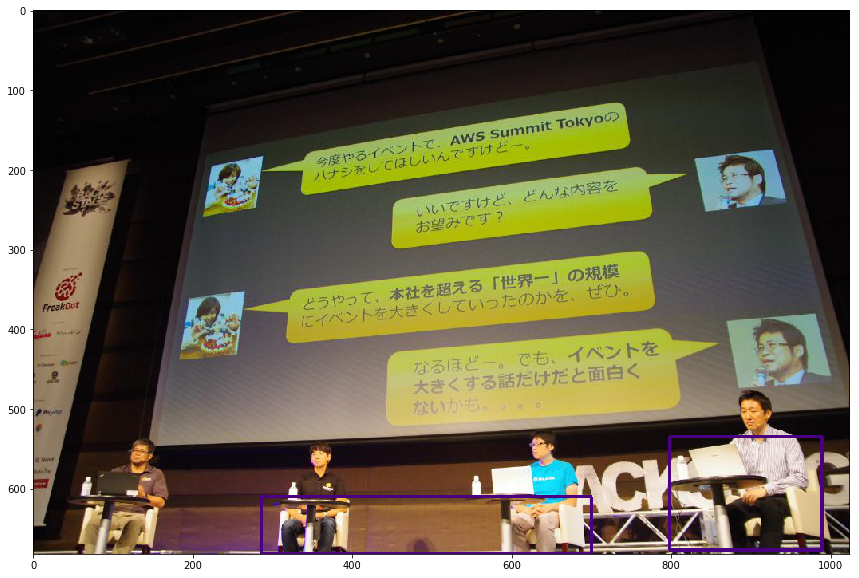

In [100]:
show_tuple_relation(df_test_pos, 3100, test_mode=True)

In [116]:
df_trip = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-relationship-triplets.csv'))
df_trip.head()

,LabelName1,LabelName2,RelationshipLabel
0,/m/01599,/m/04bcr3,on
1,/m/05r655,/m/0h8my_4,holds
2,/m/05r655,/m/03k3r,on
3,/m/04yx4,/m/0l14j_,holds
4,/m/05r655,/m/080hkjn,wears


In [117]:
df_trip.loc[df_trip.RelationshipLabel=='is'].shape

(42, 3)

In [118]:
df_trip.shape

(329, 3)